In [209]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow import keras
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa


In [191]:
def preprocessing_model():
  input = keras.Input(shape=(600, 600, 3), name="input")
  input = tf.keras.layers.experimental.preprocessing.Resizing(600,600)(input)
  central_crop = tf.keras.layers.experimental.preprocessing.CenterCrop(height=150,width=150)(input) 
  resized_single_crop = tf.keras.layers.experimental.preprocessing.Resizing(300,300)(central_crop)
  
  random_crop = tf.keras.layers.experimental.preprocessing.RandomCrop(height=75,width=75)(input)
  
  random_crop0 = tf.keras.layers.experimental.preprocessing.Resizing(300,300)(random_crop)


  translate_1 = keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(0.25,0.25))(input)

  central_cr = tf.keras.Model(inputs=input,outputs=resized_single_crop)
  random_patch = tf.keras.Model(inputs=input,outputs=random_crop0)
  translate = tf.keras.Model(inputs=input,outputs=translate_1)
  identity = tf.keras.Model(inputs=input,outputs=tf.identity(input))
  arr = [central_cr,random_patch,translate,identity]
  return arr

In [360]:
def aug_pipeline(images):
  central_crop = iaa.Sequential([iaa.CenterCropToFixedSize(300,300),iaa.Resize(size=(600,600))], random_order=False)
  identity = iaa.Identity()
  translate_x = iaa.TranslateX(percent=(-0.45, 0.45))
  translate_y = iaa.TranslateY(percent=(-0.45, 0.45))  
  patch = iaa.Crop(percent=0.4, keep_size=True)
  
  aug = [central_crop, identity, patch, translate_x, translate_y]
  return aug[np.random.randint(low=0,high=4)](images=images.numpy())

In [361]:
def parsing_fn(serialized):
    features = \
        {
            'image': tf.io.FixedLenFeature([], tf.string),
            'species': tf.io.FixedLenFeature([80000], tf.int64),
            #'genus': tf.io.FixedLenFeature([516], tf.int64),
            #'family': tf.io.FixedLenFeature([124], tf.int64),           
        }
    parsed_example = tf.io.parse_single_example(serialized=serialized,
                                             features=features)
    image_raw = parsed_example['image']
    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.io.decode_jpeg(image_raw)    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)
    #image = (image / 255.0)
    species = parsed_example['species']
    #genus = parsed_example['genus']
    #family = parsed_example['family']
    return image, species

In [362]:
#tf.cast(rand_aug(images=tf.cast(images, tf.uint8).numpy()), tf.float16)
AUTO = tf.data.AUTOTUNE
testing_path = 'train_0.tfrecord'
augmentation_models = preprocessing_model()
random_augmentation = lambda images: tf.cast(tf.squeeze(augmentation_models[np.random.randint(low=0,high=3)].predict(images),axis=0), tf.float16)

random_augmentation = lambda images: tf.cast(aug_pipeline(images), tf.float16)

dataset = tf.data.TFRecordDataset(filenames=testing_path)
parsed_dataset = dataset.map(parsing_fn).batch(1)
parsed_dataset = parsed_dataset.map(lambda x,y: (tf.py_function(random_augmentation, [x], [tf.float16])[0], y), num_parallel_calls=AUTO)


In [363]:
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 

#image = tf.expand_dims(image,axis=0)
#print(output.shape)

(1, 600, 600, 3)
Original image


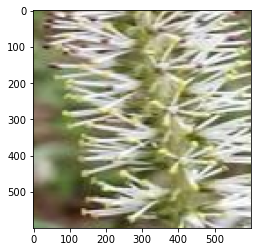

In [378]:
image, label = iterator.get_next()
print(image.shape)

#output = image[0]
#output = (output * 255)
#output
#norm_image = cv2.normalize(output, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
#image = np.asarray(image[0])
image = image[0].numpy().astype(np.uint8)

print('Original image')
plt.imshow(image)
plt.show()
